In [43]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.example import forest
import gym
import numpy as np
import sys
import os
from numpy.random import choice
import pandas as pd
import seaborn as sns
np.random.seed(42)

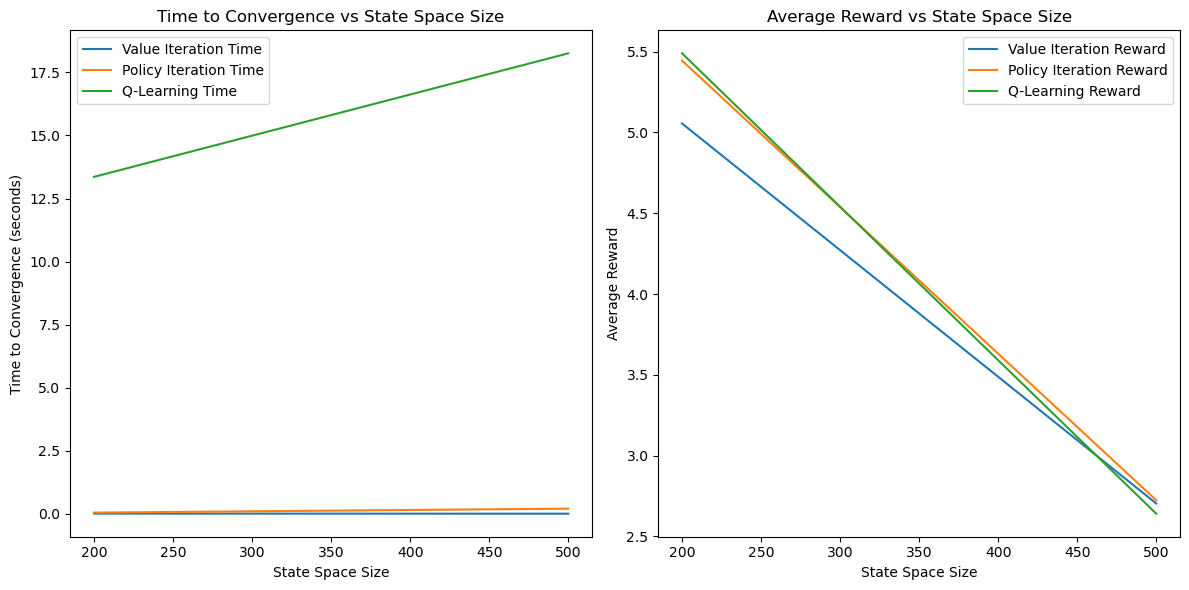

In [45]:
# New function to run experiments for a given state size
def run_experiments(state_size):
    P, R = forest(S=state_size, r1=100, r2=15, p=0.01)
    discount_factor = 0.9

    # Run Value Iteration
    vi = ValueIteration(P, R, gamma=discount_factor)
    vi.run()
    vi_reward = test_policy(P, R, vi.policy)

    # Run Policy Iteration
    pi = PolicyIteration(P, R, gamma=discount_factor)
    pi.run()
    pi_reward = test_policy(P, R, pi.policy)

    # Run Q-Learning
    q = QLearning(P, R, gamma=discount_factor, n_iter=1000000)
    q.run()
    q_reward = test_policy(P, R, q.policy)

    return {
        'State Size': state_size,
        'VI Time': vi.time,
        'PI Time': pi.time,
        'Q-Learning Time': q.time,
        'VI Reward': vi_reward,
        'PI Reward': pi_reward,
        'Q-Learning Reward': q_reward
    }

# Run experiments for state sizes 200 and 500
results = [run_experiments(200), run_experiments(500)]
results_df = pd.DataFrame(results)


# Plotting code for State Space Size Analysis (same as previously provided)
import matplotlib.pyplot as plt

# Assuming results_df is the DataFrame containing the results
# Columns: ['State Size', 'VI Time', 'PI Time', 'Q-Learning Time', 'VI Reward', 'PI Reward', 'Q-Learning Reward']

# Plotting Time to Convergence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df['State Size'], results_df['VI Time'], label='Value Iteration Time')
plt.plot(results_df['State Size'], results_df['PI Time'], label='Policy Iteration Time')
plt.plot(results_df['State Size'], results_df['Q-Learning Time'], label='Q-Learning Time')
plt.xlabel('State Space Size')
plt.ylabel('Time to Convergence (seconds)')
plt.title('Time to Convergence vs State Space Size')
plt.legend()

# Plotting Average Reward
plt.subplot(1, 2, 2)
plt.plot(results_df['State Size'], results_df['VI Reward'], label='Value Iteration Reward')
plt.plot(results_df['State Size'], results_df['PI Reward'], label='Policy Iteration Reward')
plt.plot(results_df['State Size'], results_df['Q-Learning Reward'], label='Q-Learning Reward')
plt.xlabel('State Space Size')
plt.ylabel('Average Reward')
plt.title('Average Reward vs State Space Size')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [47]:
def test_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

In [48]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", "Policy", "Iteration", 
                                  "Time", "Reward", "Value Function"])
    for eps in epsilon:
        vi = ValueIteration(P, R, gamma=discount, epsilon=eps, max_iter=int(1e15))
        vi.run()
        reward = test_policy(P, R, vi.policy)
        info = [float(eps), vi.policy, vi.iter, vi.time, reward, vi.V]
        df_length = len(vi_df)
        vi_df.loc[df_length] = info
    return vi_df

In [49]:
vi_df = trainVI(P, R, epsilon=[1e-1, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15])
vi_df

,Epsilon,Policy,Iteration,Time,Reward,Value Function
0,1.000000e-01,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",79,0.008625,2.738914,"(4.710556185449387, 5.239434944489701, 5.23943..."
1,1.000000e-03,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",119,0.006659,2.739274,"(4.7117745667154995, 5.240595870281114, 5.2405..."
2,1.000000e-06,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",179,0.009267,2.737170,"(4.711792669916437, 5.240613400253226, 5.24061..."
3,1.000000e-09,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",239,0.014802,2.731085,"(4.711792702216012, 5.240613431989174, 5.24061..."
4,1.000000e-12,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",299,0.021815,2.776971,"(4.711792702273827, 5.240613432046434, 5.24061..."
5,1.000000e-15,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",359,0.027157,2.738435,"(4.7117927022739305, 5.240613432046538, 5.2406..."


In [50]:
pi = PolicyIteration(P, R, gamma=0.9, max_iter=1e6)
pi.run()
pi_pol = pi.policy
pi_reward = test_policy(P, R, pi_pol)
pi_iter = pi.iter
pi_time = pi.time
pi_iter, pi_time, pi_reward

(46, 0.20215797424316406, 2.7603856355958247)

In [51]:
#Q-Learning

In [52]:
def trainQ(P, R, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = test_policy(P, R, q.policy)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

In [53]:
alpha_decs = [0.99, 0.999]
alpha_mins =[0.001, 0.0001]
eps = [10.0, 1.0]
eps_dec = [0.99, 0.999]
iters = [1000000, 10000000]
q_df = trainQ(P, R, discount=0.9, alpha_dec=alpha_decs, alpha_min=alpha_mins, 
            epsilon=eps, epsilon_decay=eps_dec, n_iter=iters)

1: 2.666105368306511
2: 2.6321789934574085
3: 2.587151192786994
4: 2.4888699180722726
5: 2.660115547767304
6: 2.6876321788605884
7: 2.614650775382493
8: 2.57110465473781
9: 2.6492138719865204
10: 2.5859206564746224
11: 2.667585196277768
12: 2.6419929199456202
13: 0.784
14: 2.5875275552319734
15: 2.6038132948151183
16: 2.602362852814849
17: 2.7586731784352065
18: 2.8024588528993633
19: 2.710815646000848
20: 2.8308111885490526
21: 2.7752671952777344
22: 2.838853838416092
23: 2.7588423492072676
24: 2.7488239432996813
25: 2.6929470714028203
26: 2.7571220509135594
27: 2.81685622163267
28: 2.831148743822442
29: 2.7132689055675616
30: 2.780304995772671
31: 2.7031739342046692
32: 2.858870324557412


In [54]:
q_df

,Iterations,Alpha Decay,Alpha Min,Epsilon,Epsilon Decay,Reward,Time,Policy,Value Function,Training Rewards
0,1000000,0.990,0.0010,10.0,0.990,2.666105,18.183133,"(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...","(4.7127911442892305, 5.241085593437703, 5.2405...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1000000,0.990,0.0001,10.0,0.990,2.632179,18.310553,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ...","(4.673797417307683, 5.202118492157029, 4.39006...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1000000,0.999,0.0010,10.0,0.990,2.587151,18.296920,"(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","(4.710389493573358, 5.240545564346826, 5.24177...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1000000,0.999,0.0001,10.0,0.990,2.488870,18.383419,"(0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...","(4.711311979551522, 5.240241776270106, 5.08372...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,1000000,0.990,0.0010,10.0,0.999,2.660116,18.240869,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","(4.711672555740204, 5.240653015793944, 5.24063...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
5,1000000,0.990,0.0001,10.0,0.999,2.687632,18.157078,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","(4.667448144203404, 5.196201894551647, 4.35921...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
6,1000000,0.999,0.0010,10.0,0.999,2.614651,18.345108,"(0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, ...","(4.710600615323353, 5.239719034833075, 5.24100...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
7,1000000,0.999,0.0001,10.0,0.999,2.571105,18.342269,"(0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","(4.708720624561361, 5.237901610366477, 5.13452...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
8,1000000,0.990,0.0010,1.0,0.990,2.649214,18.286777,"(0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","(4.710925716706953, 5.239992409067056, 5.24059...","[0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,1000000,0.990,0.0001,1.0,0.990,2.585921,18.307410,"(0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","(4.672331793505061, 5.200817842528428, 4.35059...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


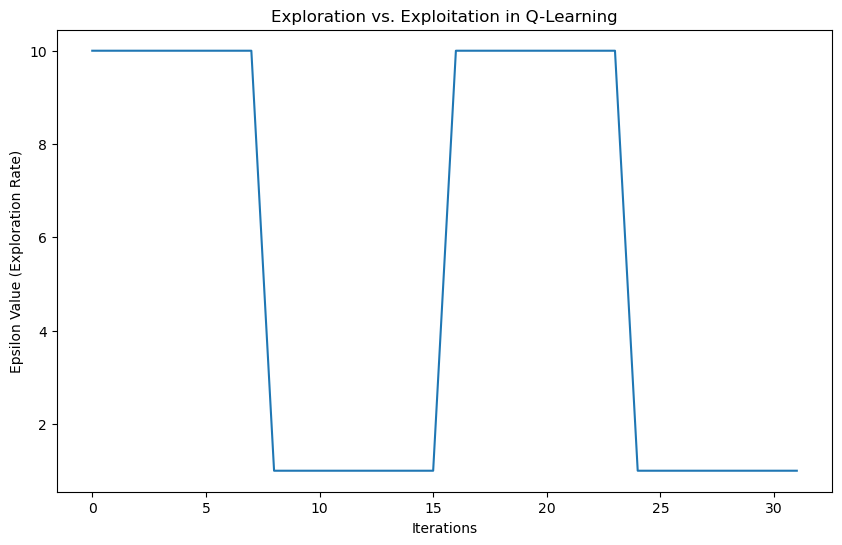

In [56]:
def plot_exploration_vs_exploitation(q_learning_df):
    # Assuming 'Epsilon' is a column in your q_learning_df DataFrame
    epsilons = q_learning_df['Epsilon'].tolist()
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons)
    plt.xlabel('Iterations')
    plt.ylabel('Epsilon Value (Exploration Rate)')
    plt.title('Exploration vs. Exploitation in Q-Learning')
    plt.show()

# Example usage with your Q-Learning DataFrame
plot_exploration_vs_exploitation(q_df)


In [57]:
pi_pol == q_df.Policy

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
Name: Policy, dtype: bool

In [58]:
# Assuming q_df is structured correctly
q_df_mean = q_df.groupby("Iterations")[numeric_cols].mean()
print(q_df_mean)

q_df_mean_alpha_decay = q_df.groupby("Alpha Decay")[numeric_cols].mean()
q_df_mean_alpha_min = q_df.groupby("Alpha Min")[numeric_cols].mean()
print(q_df_mean_alpha_decay)
print(q_df_mean_alpha_min)

            Iterations  Alpha Decay  Alpha Min  Epsilon  Epsilon Decay  \
Iterations                                                               
1000000      1000000.0       0.9945    0.00055      5.5         0.9945   
10000000    10000000.0       0.9945    0.00055      5.5         0.9945   

              Reward        Time  
Iterations                        
1000000     2.501889   18.267080  
10000000    2.773640  171.674391  
             Iterations  Alpha Decay  Alpha Min  Epsilon  Epsilon Decay  \
Alpha Decay                                                               
0.990         5500000.0        0.990    0.00055      5.5         0.9945   
0.999         5500000.0        0.999    0.00055      5.5         0.9945   

               Reward       Time  
Alpha Decay                       
0.990        2.585724  94.826274  
0.999        2.689805  95.115196  
           Iterations  Alpha Decay  Alpha Min  Epsilon  Epsilon Decay  \
Alpha Min                                        

In [59]:
# Select only numeric columns for the groupby mean operation
numeric_columns = q_df.select_dtypes(include=np.number).columns
q_df_mean = q_df.groupby("Epsilon Decay")[numeric_columns].mean()

# Now you can safely display the mean values
q_df_mean

,Iterations,Alpha Decay,Alpha Min,Epsilon,Epsilon Decay,Reward,Time
Epsilon Decay,,,,,,,
0.990,5500000.0,0.9945,0.00055,5.5,0.990,2.694991,94.912016
0.999,5500000.0,0.9945,0.00055,5.5,0.999,2.580538,95.029454


In [60]:
pi_df = pd.DataFrame({
    'Iteration': [pi_iter],
    'Value Function': [pi.V],  # Store the value function here
    'Reward': [pi_reward],
    'Time': [pi_time]
})

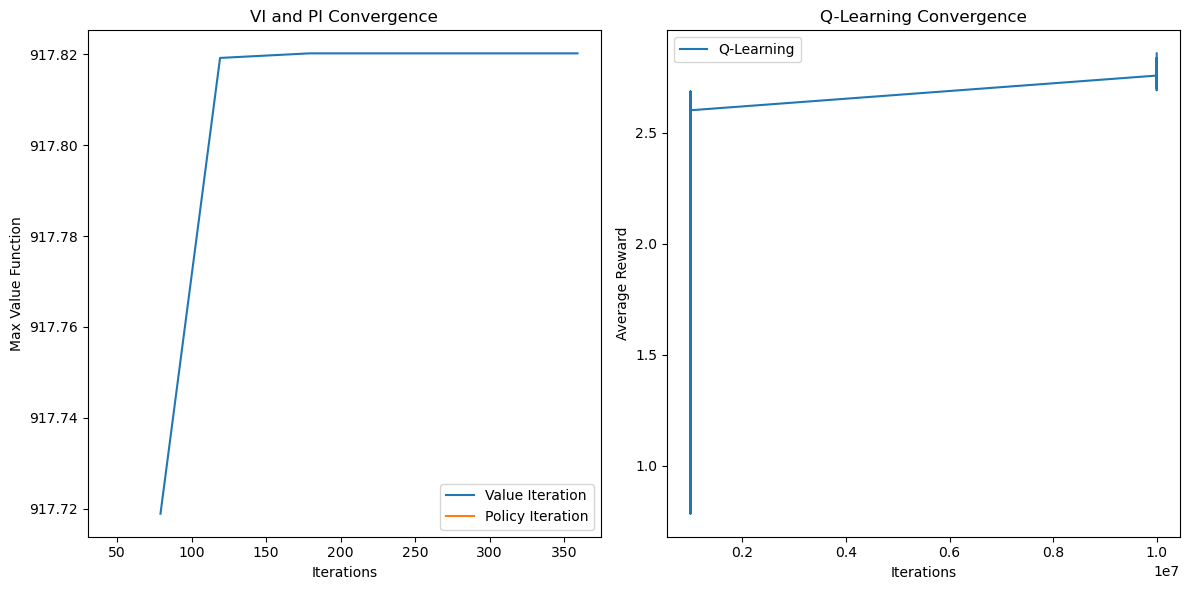

In [61]:
# Value Iteration and Policy Iteration Convergence Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(vi_df['Iteration'], vi_df['Value Function'].apply(lambda x: max(x)), label='Value Iteration')
plt.plot(pi_df['Iteration'], pi_df['Value Function'].apply(lambda x: max(x)), label='Policy Iteration')
plt.xlabel('Iterations')
plt.ylabel('Max Value Function')
plt.title('VI and PI Convergence')
plt.legend()

# Q-Learning Convergence Plot
plt.subplot(1, 2, 2)
plt.plot(q_df['Iterations'], q_df['Reward'], label='Q-Learning')
plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Q-Learning Convergence')
plt.legend()
plt.tight_layout()
plt.show()

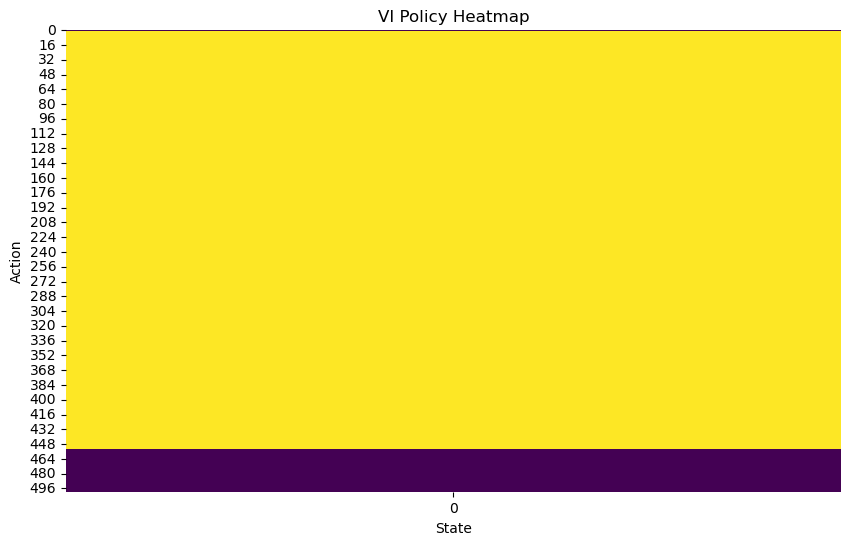

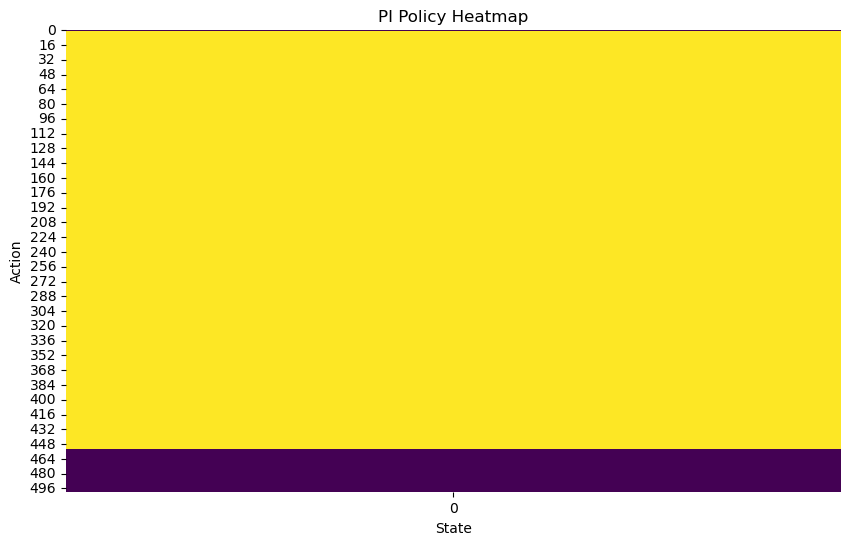

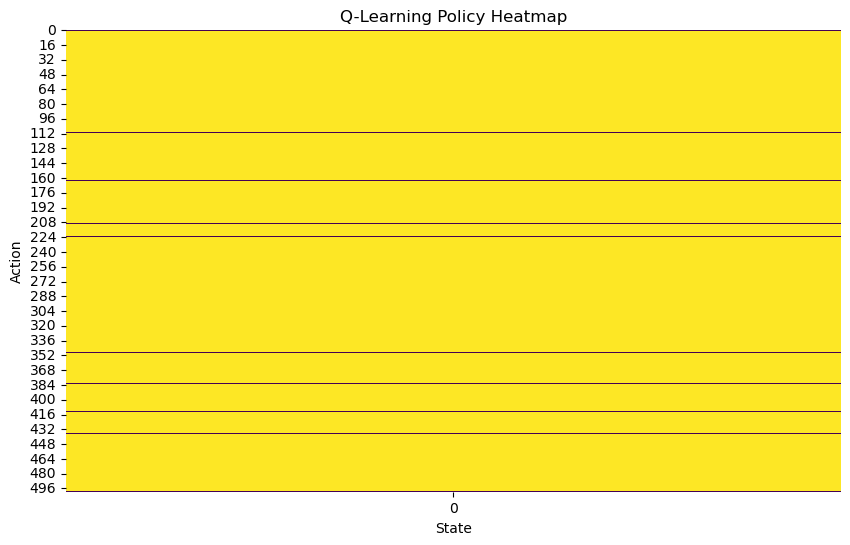

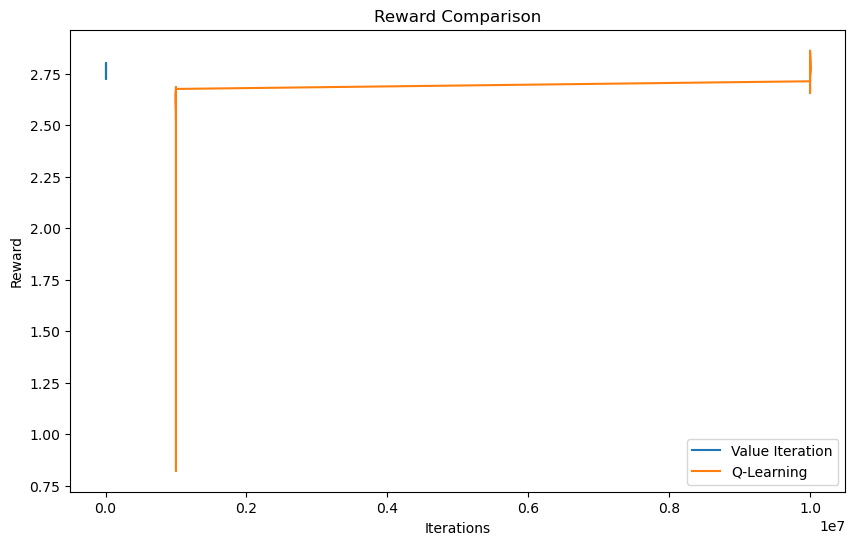

In [42]:
# Example for VI Policy Heatmap
vi_policy_matrix = np.array(vi_df['Policy'].iloc[0]).reshape(-1, 1)  # Adjust the reshape parameters as needed
plt.figure(figsize=(10, 6))
sns.heatmap(vi_policy_matrix, cmap='viridis', cbar=False)
plt.title('VI Policy Heatmap')
plt.xlabel('State')
plt.ylabel('Action')
plt.show()

# Example for PI Policy Heatmap
pi_policy_matrix = np.array(pi.policy).reshape(-1, 1)  # Adjust the reshape parameters as needed
plt.figure(figsize=(10, 6))
sns.heatmap(pi_policy_matrix, cmap='viridis', cbar=False)
plt.title('PI Policy Heatmap')
plt.xlabel('State')
plt.ylabel('Action')
plt.show()

# Extracting the policy for visualization
# Assuming you want to visualize the policy of the last Q-Learning run
q_policy = q_df.iloc[-1]['Policy']  # This gets the policy of the last row in q_df

# Reshape the policy for the heatmap
q_policy_matrix = np.array(q_policy).reshape(-1, 1)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(q_policy_matrix, cmap='viridis', cbar=False)
plt.title('Q-Learning Policy Heatmap')
plt.xlabel('State')
plt.ylabel('Action')
plt.show()


# Repeat similar heatmap code for PI and Q-Learning policies

plt.figure(figsize=(10, 6))
plt.plot(vi_df['Epsilon'], vi_df['Reward'], label='Value Iteration')  # Check if 'Epsilon' is the correct parameter
plt.plot(q_df['Iterations'], q_df['Reward'], label='Q-Learning')
plt.xlabel('Iterations')  # Updated label
plt.ylabel('Reward')
plt.title('Reward Comparison')
plt.legend()
plt.show()

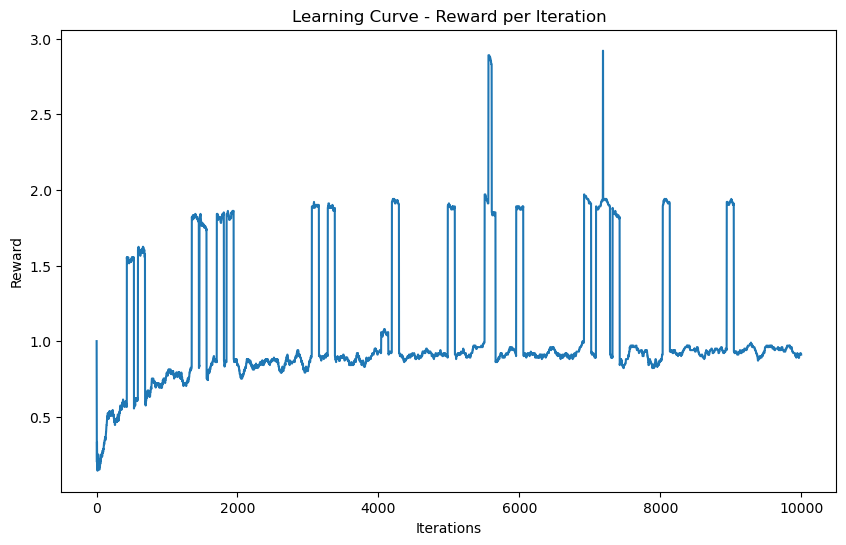

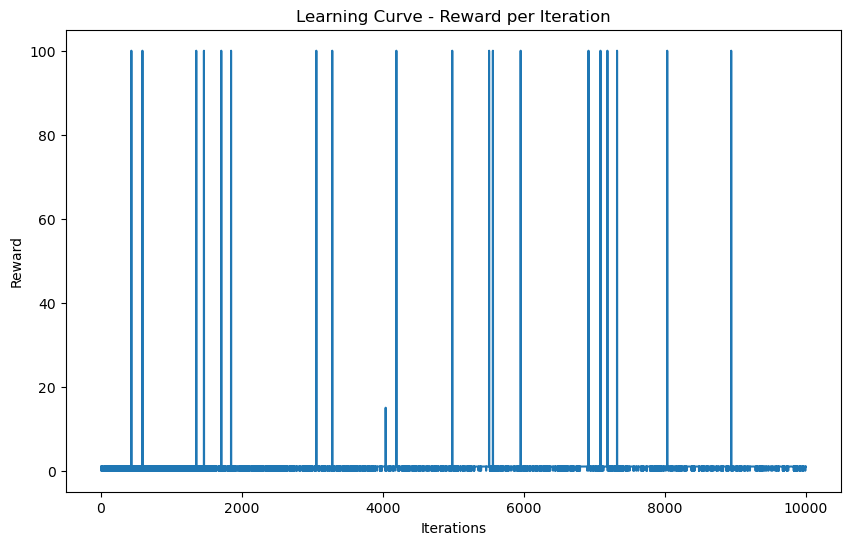

In [74]:
def smooth_rewards(rewards, window_size=50):
    smoothed_rewards = [np.mean(rewards[i-window_size:i+1]) if i >= window_size else np.mean(rewards[:i+1]) for i in range(len(rewards))]
    return smoothed_rewards

# Smoothing the rewards with a window size of your choice
smoothed_rewards = smooth_rewards(last_run_training_rewards, window_size=100)
plot_learning_curve_for_run(smoothed_rewards)

def plot_learning_curve_for_run(training_rewards):
    # Extracting rewards for each iteration
    rewards = [reward for reward in training_rewards]

    iterations = list(range(1, len(rewards) + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, rewards)
    plt.xlabel('Iterations')
    plt.ylabel('Reward')
    plt.title('Learning Curve - Reward per Iteration')
    plt.show()

# Extract Training Rewards for the last run in q_df and plot the learning curve
last_run_training_rewards = q_df.iloc[-1]['Training Rewards']
plot_learning_curve_for_run(last_run_training_rewards)

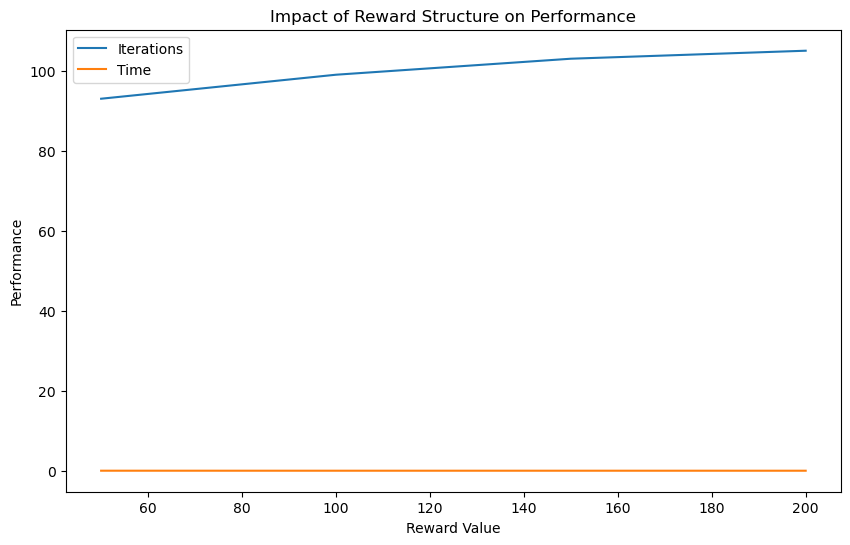

In [64]:
def run_experiment_with_different_rewards(reward_values):
    results = []
    for r_value in reward_values:
        P, R = forest(S=200, r1=r_value, r2=15, p=0.01)  # Adjust parameters as needed
        vi = ValueIteration(P, R, gamma=0.9)
        vi.run()
        results.append({'Reward Value': r_value, 'Iterations': vi.iter, 'Time': vi.time})
    return pd.DataFrame(results)

reward_values = [50, 100, 150, 200]  # Example reward values
reward_impact_df = run_experiment_with_different_rewards(reward_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(reward_impact_df['Reward Value'], reward_impact_df['Iterations'], label='Iterations')
plt.plot(reward_impact_df['Reward Value'], reward_impact_df['Time'], label='Time')
plt.xlabel('Reward Value')
plt.ylabel('Performance')
plt.title('Impact of Reward Structure on Performance')
plt.legend()
plt.show()


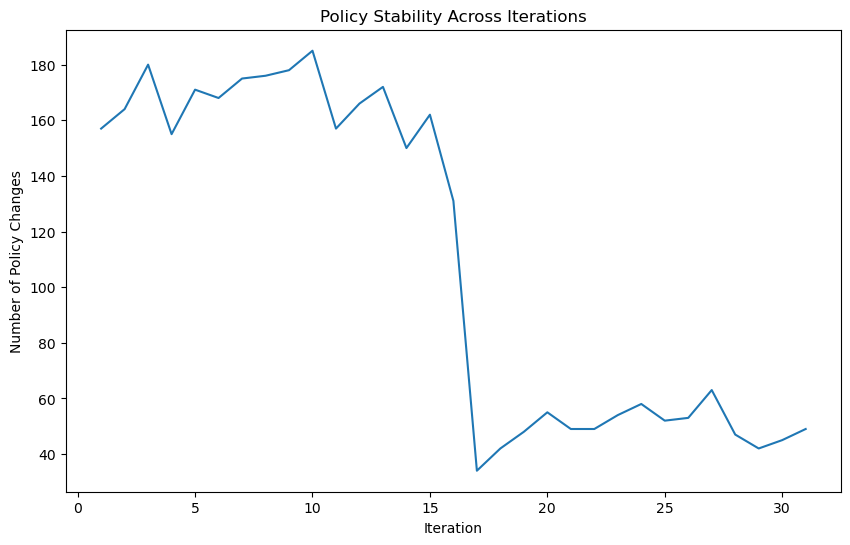

In [76]:
def plot_policy_stability(q_df):
    # Extract policies from the DataFrame
    policies = q_df['Policy'].tolist()
    # Calculate the number of changes between consecutive policies
    # Comparing element-wise and summing the number of changes
    policy_changes = [sum(p1 != p2 for p1, p2 in zip(pol1, pol2)) 
                      for pol1, pol2 in zip(policies[:-1], policies[1:])]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(policy_changes) + 1), policy_changes)
    plt.xlabel('Iteration')
    plt.ylabel('Number of Policy Changes')
    plt.title('Policy Stability Across Iterations')
    plt.show()

# Example usage
plot_policy_stability(q_df)  # Pass the whole DataFrame

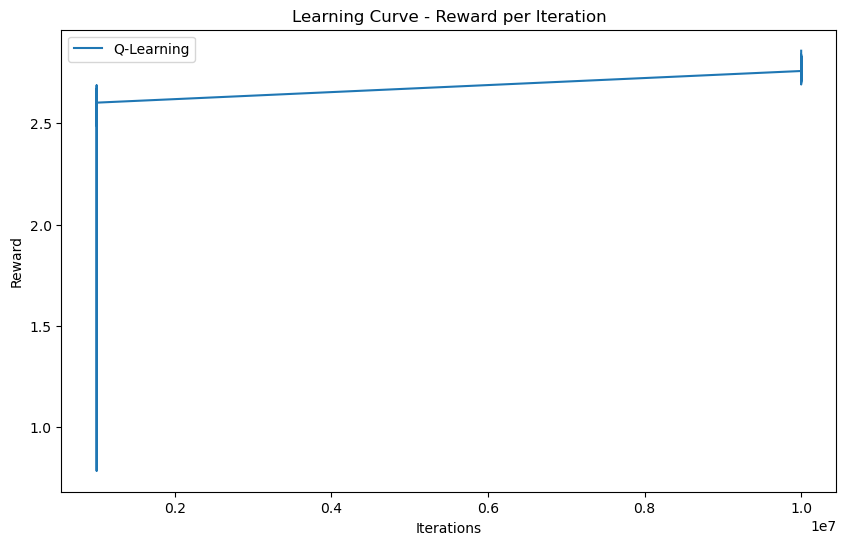

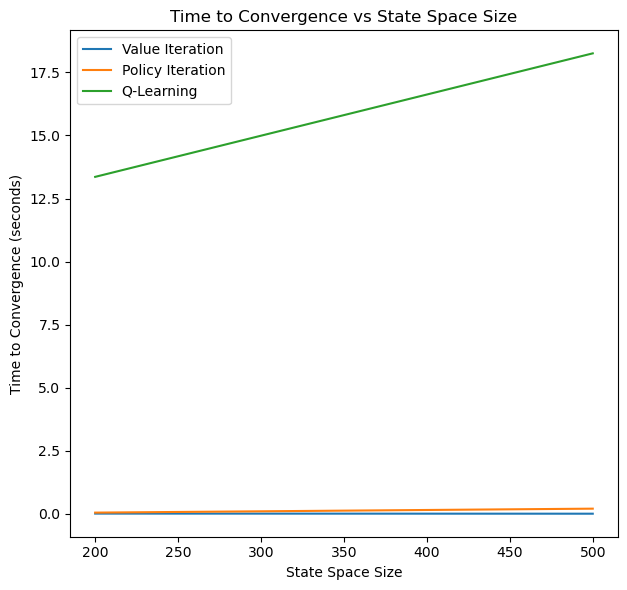

In [78]:
# Assuming you have a DataFrame `q_df` with a 'Reward' column for each iteration
# Learning Curve - Reward per Iteration for Q-Learning
plt.figure(figsize=(10, 6))
plt.plot(q_df['Iterations'], q_df['Reward'], label='Q-Learning')
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Learning Curve - Reward per Iteration')
plt.legend()
plt.show()

# Assuming you have a DataFrame `results_df` with 'VI Time', 'PI Time', and 'Q-Learning Time' columns
# Time to Convergence vs State Space Size
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df['State Size'], results_df['VI Time'], label='Value Iteration')
plt.plot(results_df['State Size'], results_df['PI Time'], label='Policy Iteration')
plt.plot(results_df['State Size'], results_df['Q-Learning Time'], label='Q-Learning')
plt.xlabel('State Space Size')
plt.ylabel('Time to Convergence (seconds)')
plt.title('Time to Convergence vs State Space Size')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
#heatmaps for pi, vi, q learning